# Von Maximilian Horster und Yanik Plutte

# 1.0 Libaries

##### Standardbibliotheken
- os: ermöglicht Erstellung von Ordnern und Navigation durch die Ordnerstruktur des Projektes
- sys: sys.path.append erlaubt das Importieren von Klassen, welche außerhalb definiert sind (im src-Ordner)
- torch & torch.nn: Standard Pytorch Klassen
- torchvision datasets & transforms: ermöglicht Import von den Datensets (MNIST & CIFAR10) sowie die Transformation dieser
- matplotlib.pyplot: ermöglicht das Plotten der Bilder / Ergebnisse

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable

import numpy as np

import os

import matplotlib.pyplot as plt

# 2.0 General

##### Gibt aus ob Cuda verfügbar ist oder der CPU genutzt wird

In [2]:
print('Cuda is available:',torch.cuda.is_available(),'\n')

Cuda is available: True 



# 3.0 Hyperparameters

##### Hyperparameter zur Anpassung des Netztes sowie Parameter im Training-Loop

##### ``input_size``: Eingabegröße in die erste Schicht des Netzwerkes
##### ``hidden_dim``: Dimensionsgröße der Hidden Layer
##### ``batch_size``: 
##### ``num_epochs``: Anzahl der zu trainierenden Epochen
##### ``learn_rate``: Lernrate

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = (8*4*4)
hidden_dim = 128

batch_size = 8

num_epochs = 2
learn_rate = 0.0002


# 4.0 Load Data
#####

- Erstellen der Ordnerstruktur falls diese nicht existiert
- Download des Datensatzes, Aufteilung in Train=True und Train=False
- Definition des Data_Loaders, Aufteilung in Train und Test Daten
- Nutzen von "shuffle" um eine Anpassung des Netzwerkes an die Reihenfolge der Daten zu vermeiden

In [4]:
# create folder structure if it does not exist
folder_path = "../../data/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


#MNIST Dataset
    #Create Folder, transorm to Tensor
train_dataset = torchvision.datasets.MNIST(
    root=folder_path, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.01307),(0.3081))]), download=True
)

test_dataset = torchvision.datasets.MNIST(
    root=folder_path, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.01307),(0.3081))])
)

#Data Loader in Training
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True #use shuffle to not let the network train on the order of data
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

#show MNIST Dataset

# figure= plt.figure(figsize=(10,8))
# spalten, zeilen = 5,5
# for i in range(1,spalten*zeilen+1):
#     sample_idx = torch.randint(len(train_dataset),size=(1,)).item()
#     image , label = train_dataset[sample_idx]
#     figure.add_subplot(spalten,zeilen,i)
#     plt.title(label, weight='bold')
#     plt.imshow(image.squeeze(), cmap='gray')
# plt.subplots_adjust(wspace=0.3,hspace=0.6)
# plt.show()


# 5.0 Classes

##### Import von Klassen

- Import des CNN AutoEncoders aus src
- Import des Klassifizierungsnetzwerkes aus src

In [5]:
# Load necessary models for classification
    # reduce complexitiy and mass of code

import sys

sys.path.append('../src/')

from classes.autoencoder.autoencoderCNN import AutoEncoderCNN
from classes.imageclassification.classification import MNIST_Classification_Class

## 5.1 Load AE Model

#####
- Initiierung des ``AutoEncoders`` als Model
- Laden des trainierten (gewichtangepassten) Netzes über ``torch.load``

- Auswahl des ``Encoder`` des AutoEncoder

In [6]:
#Define AutoEncoder Model and use encoder

ModelAE = AutoEncoderCNN().to(device)
ModelAE = torch.load("ep2.pth", map_location=device)

ModelAE.eval()

trained_encoder = ModelAE.encode


## 5.2 Load Classification Model

#####
- Initiieren der ``Classification_Class`` als Model

In [7]:
#define Image classification model 

Model_Classifier = MNIST_Classification_Class(input_size, hidden_dim).to(device)

#  6.0 Function: View Predictions

#####
- Funktion zur Ausgabe des zu klassifizierenden Bildes und der Predictions des Netzwerkes als Balkendiagramm über 0-9

In [8]:
def view_classifications(img,pred):
    pred = pred.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) 
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
    ax1.set_title('Original MNIST Image')
    
    bars = ax2.barh(np.arange(10), pred)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))               #Create bar graph to display prediction probability
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    for bar, val in zip(bars, pred):
        if not (val < 0.3):
            ax2.text(val, bar.get_y() + bar.get_height() / 2, round(val, 2), va='center')

    plt.tight_layout()
    plt.show()
    plt.close()

# 7.0 Training

##### 
- Abfrage nach fortführen des Trainings mit bereits trainierten Netzen - anschließender load des Netzes
- ``CrossEntropyLoss`` als Verlustfunktion
- Als Optimizer wird ``Adam`` mit der in den Hyperparametern festgelegten Lernrate
- for-Schleife für definierte Anzahl der ``Epochen``
- for schleife für definierte ``Batch_Size``

- Laden des Bildes sowie des ``Labels`` über den ``Train_Loader``
- Durchlaufen des Bildes durch ``AutoEncoder`` und im folgenden durch den ``Classifier``

- Berechnung des Loss durch die ``Verlustfunktion`` anhand des Übergebenen Output (Prediction) und des Label aus dem Trainingsdatensatz

Image: 1 of 7500.0 in Epoche: 1 // Loss: 1.66996 


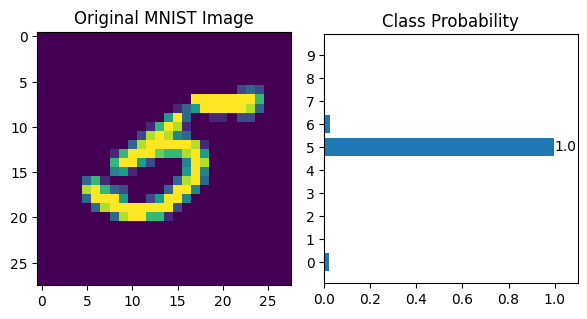

Image: 513 of 7500.0 in Epoche: 1 // Loss: 1.48899 


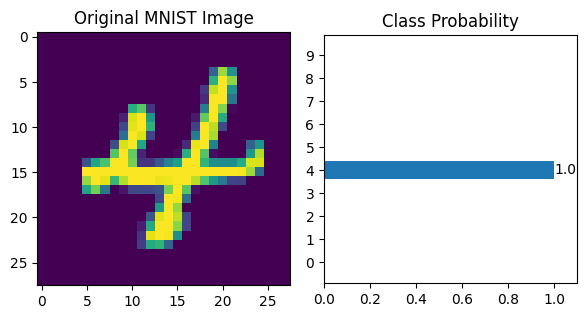

Image: 1025 of 7500.0 in Epoche: 1 // Loss: 1.82938 


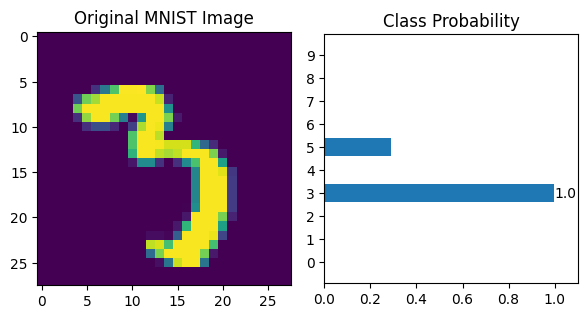

Image: 1537 of 7500.0 in Epoche: 1 // Loss: 1.52726 


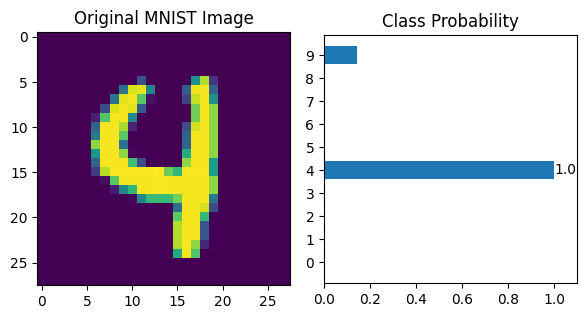

Image: 2049 of 7500.0 in Epoche: 1 // Loss: 1.46603 


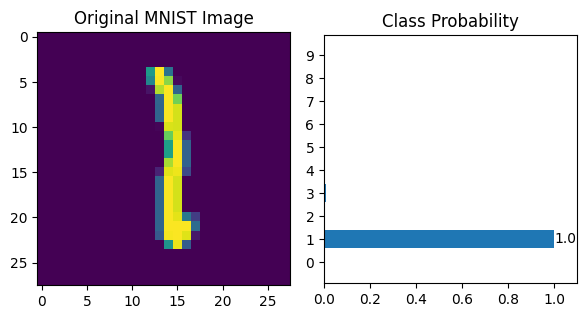

Image: 2561 of 7500.0 in Epoche: 1 // Loss: 1.51005 


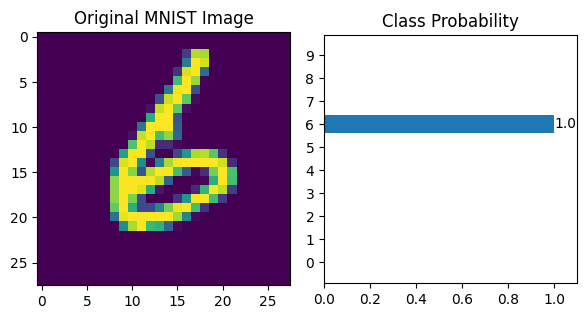

KeyboardInterrupt: 

In [9]:
#Load Model / Continue Training
continue_training = True

PATH = "classification_model.pth"

if continue_training:
    Model_Classifier = torch.load(PATH).to(device)

#criterion / lf
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(params=Model_Classifier.parameters(),lr=learn_rate)

for epoch in range(num_epochs):
    for batch_id, (Bild,Label) in enumerate(train_loader):
        Bild = Bild.to(device)
        Label = Label.to(device)

        OutputEncoder = trained_encoder(Bild)
        OutputEncoder = OutputEncoder.to(device)
        OutputEncoder = OutputEncoder.view(OutputEncoder.size(0),-1)

        output = Model_Classifier(OutputEncoder)

        loss = criterion(output,Label)

        if batch_id %512 == 0:
            print('Image:',batch_id+1,'of',60000/batch_size,'in Epoche:',epoch+1,'// Loss: %.5f ' % loss)
            view_classifications(Bild[0].cpu().view(1,28,28),output[0])
        

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    print('Epoche:',epoch+1, 'Loss: %.5f ' % loss)

# 8.0 Save Model Neural Network

#####
- Speichern des Model um antrainierte Gewichte zu sichern
- Name der Datei ist als Variable PATH definiert

In [ ]:
torch.save(Model_Classifier,PATH)

# Confusuion Matrix

In [ ]:
# label_list = torch.zeros(batch_size)
# pred_list = torch.zeros(batch_size)

# print(label_list, pred_list)

# with torch.no_grad():
#     for data,target in test_dataset:
#         data = data.reshape(-1,28,28).to(device)
#         target = target.to(device)

#         outconf= model1(data)

        

# Evaluation

In [ ]:
# model1 = torch.load(FILE)

# with torch.no_grad():
#     for batch_id, (data,target) in enumerate(test_loader):
#         data = data.reshape(-1,28*28).to(device)  #[100, 1,28,28] > [100,734] ?
#         target = target.to(device)
        
#         output = model1(data) #was macht out?
#         loss = criterion(output,target) #hier out?!

#         view_classifications(data[0].view(1,28,28),output[0])
#         print('Batch in Epoche ',batch_id+1, 'Loss: %.5f ' % loss)

#     print('Epoche:',epoch+1, 'Loss: %.5f ' % loss)
